In [1]:
from fastai.collab import *
from fastai.tabular import *

## Collaborative filtering example

`collab` models use data in a `DataFrame` of user, items, and ratings.

Objective: To predict ratings given a userid and movieid and timestamp.

In [ ]:
user,item,title = 'userId','movieId','title'

In [ ]:
path = untar_data(URLs.ML_SAMPLE)
path

In [ ]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head(10)

That's all we need to create and train a model:

In [ ]:
data = CollabDataBunch.from_df(ratings, seed=42)

In [ ]:
y_range = [0,5.5] # minimum score is 0, the maximum score is 5.

In [ ]:
# I believe factors is the number of features
learn = collab_learner(data, n_factors=50, y_range=y_range)

In [ ]:
learn.fit_one_cycle(3, 5e-3)

## Movielens 100k

Let's try with the full Movielens 100k data dataset, available from http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [2]:
path=Config.data_path()/'ml-100k'

In [3]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['userId', 'movieId','rating','timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
movies = pd.read_csv(path/'u.item',  
                     delimiter='|', 
                     encoding='latin-1', # This is an old dataset, so it's encoded 'weirdly'.
                     header=None,        # No header row. So have to name the columns.
                     names=['movieId', 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])

# g0 to g19 stands for 20 possible genres. Note that for this genres: it is N-hot encoding. Cos one movie can be in multiple genres.
# Not that the genres matter anyway - we are not using them for this analysis.
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


We now have two dataframes:
- `ratings` is a list of entries of how particular users rated particular movies. Here, user and movies are changed to id (so as such movies are referred to as id, instead of a string name).
- `movies` is a list of all movies in that database, coupled with their id for reference with `ratings`.

In [5]:
len(ratings)

100000

In [6]:
# pandas merging is like the join features in SQL. 
rating_movie = ratings.merge(movies[['movieId', 'title']])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [9]:
data = CollabDataBunch.from_df(rating_movie, 
                               seed=42, 
                               valid_pct=0.1, 
                               item_name='title') 
# Default behaviour for CollabDataBunch reads the first 3 columns only.
# In order from left to right: user, item, then rating (target).
# Since we want to see thing actual titles of the movie, that's why we specify fastai to not look at the item_column (movieId)
# but instead look at the 'title' column instead.
# Note that there's no reason to use the title, we could have just stick to the default behavior, and simply relied on the movie IDs.

In [10]:
data.show_batch()

userId,title,target
587,"Kiss Me, Guido (1997)",3.0
897,Dante's Peak (1997),4.0
194,Balto (1995),3.0
138,"Rock, The (1996)",4.0
354,Grosse Pointe Blank (1997),4.0


In [11]:
y_range = [0,5.5] 
# This forces the learner to squeeze all activations in the output layer in a sigmoid function betweem 0 to 5.5
# Even though rating goes from 0.5 to 5.0, we extend the range to 0.0 to 5.5 because sigmoid symptotes to that indicated range.

In [12]:
learn = collab_learner(data, 
                       n_factors=40,
                       y_range=y_range, 
                       wd=1e-1) # Weight decay

`n_factors` refer to the number of factors. Factors is like the number of features. 40 factors is like a good number after trying out other numberse. Have to experiment from dataset to dataset. 

Intuively, each factor/features is like an aspect (or a characteristic) of the movie that has some influence on the final activation, and the amount of influence is determined by its weight. A factor of a movie can be like its genre (note that by 'genre', I am not referring to the `g0`-`g19` - I am giving an example of a characteristic of a movie), its length, the year it's released, marketing expenditure etc. There's this thing about latent factorisation, where the model would tease out the 40 different contributing aspects that defines the signature of the movie. I say 'latent' because of course we are not specifically looking out for actual concrete things like length, year or genre of the movie. A factor is just an added dimension to the model for prediction. 

Just like having 40 factors for the movies, it's the same for users. There are 40 latent characteristics of users too. Like the kind of movies they enjoy, what actors they like, etc.

The fact that the no. of features for both movies and users is intentional for the dot product to work. Rmb the objective: Given a user-movie pair, what would the user rate the movie; i.e. the prediction. Unlike the other neural network configurations we have seen so far, this collab filtering is only one layer - i.e. one matrix multiplication plus biases plus activation function. For a user-movie pair, all we have to do is to dot-product the 40 features from each entity, add the user bias and movie bias, throw it into the sigmoid function, and we got the prediction literally. Now this is something that can be visualised more easily don't you think.

Regarding bias, although there is no explicit configuration in the code, but it's accounted for. For each user, there's a bias attached to it. The same goes for each movies. Intuitively, bias is to eradicate the tendencies of users to rate too highly or too poorly. So for example, if user has a tendency to rate movies with low scores (like even his most favourite movie is a 4.0/5.0 at most instead of 5.0/5.0), then bias for that user would be positive. And vice versa the bias would be low if the user tends to rate many movies highly, even though he finds most of them average. We can generalise this concept to specific movie too. If a movie has an ensemble of popular actors, then would be rated highly, so bias should be negative. 

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


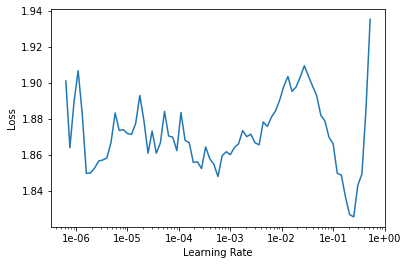

In [15]:
learn.lr_find()
learn.recorder.plot(skip_end=15)
# skip_end default value is 5. It trims the end of the graph. We do this if we know that (and it does) the graph's loss function
# diverges at the end, causing the immense loss function at the tail-end to squish the main body of the graph.
# There's also skip_start too.
# Not sure what the actual values imply. Like what units?

Again, the rule of thumb is look at the minima. Which is `2e-2`, then divide by 10. That's your `lr`.

Or, you can look at the (negatively) steepest portion of the graph. In which case, `5e-2` would be a good choice.

But a good idea is to just try. As for number of epochs, I have no idea. All I know is that if you do a lot of epochs, then you are susceptible to overfitting. Cos your model will see each training example as many times as there epochs.

In [16]:
learn.fit_one_cycle(5, 2e-2)

epoch,train_loss,valid_loss,time
0,0.969614,1.034084,01:24
1,1.015174,1.031620,01:25
2,0.915962,0.937150,01:27
3,0.771518,0.845804,01:27
4,0.551380,0.838104,01:27


TY - Notice that there's no metric (like `accuracy`). Why is that? Because it's unnecessary. The values from loss functions `train_loss` and `valid_loss` are the metrics too. They either represent the mean squared error, or just MSE.

In [17]:
learn.save('dotprod')

Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91, which corresponds to an MSE (which is what our loss function is) of `0.91**2 = 0.83`.

## Interpretation

In [18]:
print('No. of unique users: ', len(rating_movie.userId.unique()))
print('No. of unique movies: ', len(rating_movie.movieId.unique()))

No. of unique users:  943
No. of unique movies:  1682


### Setup

In [19]:
learn.load('dotprod');

In [20]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

Note the numbers don't agree, because we only take the weights from distinct users and movies from the training set. So some users and movies that are present only in the validation set would not be included.

Anyway, this brings up the cold start problem. How would the model predict ratings for a newly introduced movie, considering that it has never seen it before? How about a new user that is starting to see a bunch of movies? We have no idea what his/her interests are... IRL, applications like Netflix would get new users to declare movies they have watch before (and possibly enjoyed), to get some measure of initialisation on hand. For new movies, it would take the first few hundred ratings before being used to recommend to the remaining userbase.

In [ ]:
g = rating_movie.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

### Movie bias

In [ ]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

`Size` is 1000, because we set number of entries in `top_movies` to be 1000.

So `is_item=True`, you would pass True to say I want the items or False to say I want the users. So this is kind of like a pretty common piece of nomenclature for collaborative filtering - these IDs (users) tend to be called users, these IDs (movies) tend to be called items, even if your problem has got nothing to do with users and items at all. We just use these names for convenience. So they're just words. In our case, we want the items. This (`top_movies`) is the list of items we want, we want the bias. So this is specific to collaborative filtering.

In [ ]:
mean_ratings = rating_movie.groupby('title')['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [ ]:
item0 = lambda o:o[0]

In [ ]:
sorted(movie_ratings, key=item0)[:15]

In [ ]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

### Movie weights

In [ ]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

Often, really, there isn't really conceptually 40 latent factors involved in taste, and so trying to look at the 40 can be not that intuitive. So what we want to do is, we want to squish those 40 down to just 3. And there's something that we're not going to look into called PCA stands for Principal Components Analysis. This movie_w is a torch tensor and fastai adds the PCA method to torch tensors. What Principal Components Analysis does is it's a simple linear transformation that takes an input matrix and tries to find a smaller number of columns that cover a lot of the space of that original matrix. 

It's definitely worth knowing that taking layers of neural nets and chucking them through PCA is very often a good idea. Because very often you have way more activations than you want in a layer, and there's all kinds of reasons you would might want to play with it. 

In [ ]:
movie_pca = movie_w.pca(3)
movie_pca.shape

In [ ]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [ ]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

In [ ]:
sorted(movie_comp, key=itemgetter(0))[:10]

In [ ]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [ ]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

In [ ]:
sorted(movie_comp, key=itemgetter(0))[:10]

In [ ]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()